# Random forest

In [1]:
# Installation et chargement des requirements
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             confusion_matrix, classification_report, f1_score)

# Ignorer les warnings pour la lisibilité
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


## 1 CHARGEMENT ET PREPARATION

In [2]:
df = pd.read_csv("all_expenses_profil.csv")

# Définition cible et features
y = df["profil"]
X = df.drop(["TOTEXP23", "profil", "DUPERSID", "cum_cost_share"], axis=1, errors="ignore")

# Split Train/Test (Même graine 42 pour comparaison stricte)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} individus. Test set: {X_test.shape[0]} individus.")

Train set: 5698 individus. Test set: 1900 individus.


## 2. PIPELINE DE PRÉTRAITEMENT (Optimisé pour Arbres)

In [3]:
# Note : Les Random Forests n'ont pas besoin de scaling (StandardScaler/RobustScaler).
# On garde l'imputation et l'encodage OneHot.

num_vars = X.select_dtypes(include=["int64", "float64"]).columns
cat_vars = X.select_dtypes(include=["object", "category"]).columns

numeric_transformer = SimpleImputer(strategy="constant", fill_value=0)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preproc_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars)
    ]
)


## 3. MODÉLISATION ET GRID SEARCH

In [4]:
# Pipeline complet
pipe_rf = Pipeline([
    ('preprocess', preproc_rf),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Grille d'hyperparamètres (Basée sur votre demande + Class Weight)
parameters_rf = {
    'rf__n_estimators': [200, 500],          # Nombre d'arbres
    'rf__max_depth': [None, 10, 20],         # Profondeur max
    'rf__min_samples_split': [5, 10],        # Simplifié pour accélérer
    'rf__class_weight': [None, 'balanced'],  # CRUCIAL pour votre projet
    'rf__max_features': ['sqrt', 'log2']     # Features par split
}

print("\n--- Démarrage du Grid Search (Random Forest) ---")
print("Cela peut prendre quelques minutes...")

clf_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=parameters_rf,
    cv=3, # CV=3 suffisant ici pour gagner du temps
    scoring="f1_macro", # Cohérence avec l'analyse précédente
    n_jobs=-1,
    verbose=1
)

clf_rf.fit(X_train, y_train)


--- Démarrage du Grid Search (Random Forest) ---
Cela peut prendre quelques minutes...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__class_weight': [None, 'balanced'], 'rf__max_depth': [None, 10, ...], 'rf__max_features': ['sqrt', 'log2'], 'rf__min_samples_split': [5, 10], ...}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


## 4. RÉSULTATS 


=== Résultats Random Forest ===
Meilleurs paramètres : {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Meilleur score CV (F1 Macro) : 0.3283

--- Performances sur le Test Set ---
Accuracy : 0.7268
Macro F1-Score : 0.3381

=== Classification Report ===
              precision    recall  f1-score   support

      Faible       0.80      0.89      0.84      1519
       Moyen       0.16      0.07      0.09       209
       Élevé       0.09      0.06      0.08       172

    accuracy                           0.73      1900
   macro avg       0.35      0.34      0.34      1900
weighted avg       0.67      0.73      0.69      1900



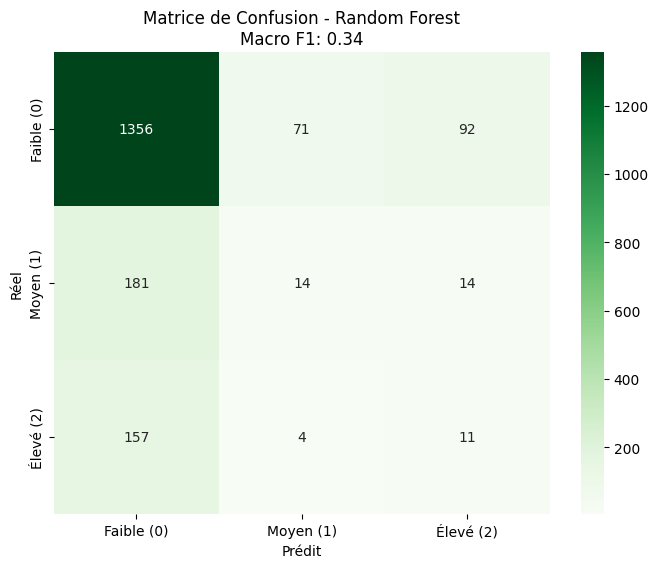

In [5]:
print("\n=== Résultats Random Forest ===")
print(f"Meilleurs paramètres : {clf_rf.best_params_}")
print(f"Meilleur score CV (F1 Macro) : {clf_rf.best_score_:.4f}")

# Prédictions
y_pred = clf_rf.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
macro_f1_rf = f1_score(y_test, y_pred, average="macro")

print("\n--- Performances sur le Test Set ---")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1-Score : {macro_f1_rf:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Faible', 'Moyen', 'Élevé']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - Random Forest\nMacro F1: {macro_f1_rf:.2f}')
plt.show()

## 5. BONUS : IMPORTANCE DES VARIABLES

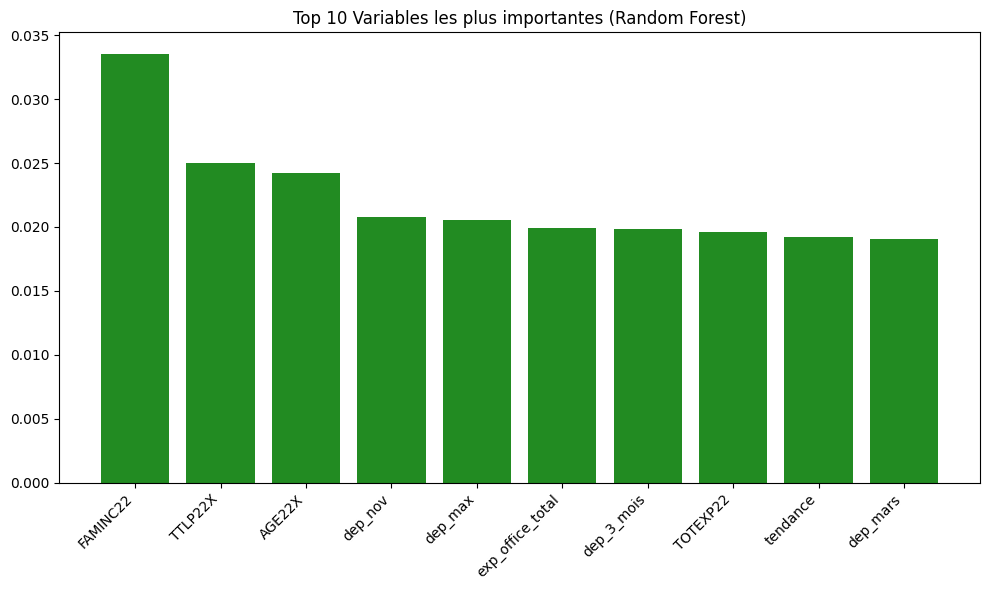

In [7]:
# On récupère le meilleur modèle du GridSearch
best_model_pipeline = clf_rf.best_estimator_
best_rf = best_model_pipeline.named_steps['rf']
preprocessor = best_model_pipeline.named_steps['preprocess']

# Récupération propre des noms de features depuis le ColumnTransformer
# Cette méthode gère automatiquement la concaténation num + cat (one-hot)
feature_names = preprocessor.get_feature_names_out()

# Nettoyage des noms (optionnel, pour faire plus joli)
feature_names = [name.replace('num__', '').replace('cat__', '') for name in feature_names]

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10] # Top 10

plt.figure(figsize=(10, 6))
plt.title("Top 10 Variables les plus importantes (Random Forest)")
plt.bar(range(10), importances[indices], align="center", color='forestgreen')
plt.xticks(range(10), np.array(feature_names)[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Modèle 4 : XGBoost

In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Encodage des labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Vérification des classes
print("Classes encodées :", np.unique(y_train_enc))

# Pipeline
pipe_xgb = Pipeline([
    ('preprocess', preproc),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    ))
])

# Grille
parameters_xgb = {
    'xgb__n_estimators': [200, 500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

# Grid Search
clf_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=parameters_xgb,
    cv=5,
    scoring="balanced_accuracy",
    n_jobs=-1,
    error_score="raise"
)

# Entraînement
clf_xgb.fit(X_train, y_train_enc)

# Résultats
print("=== Résultats XGBoost ===")
print("Meilleurs paramètres :", clf_xgb.best_params_)
print("Balanced Accuracy CV :", clf_xgb.best_score_)
print("Accuracy test :", clf_xgb.score(X_test, y_test_enc))


KeyboardInterrupt: 